# Reservoir computing clásico y cuántico en señal simple.

## Carga de librerías.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.signal import hilbert, butter, filtfilt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import random

## Generación de la señal random.

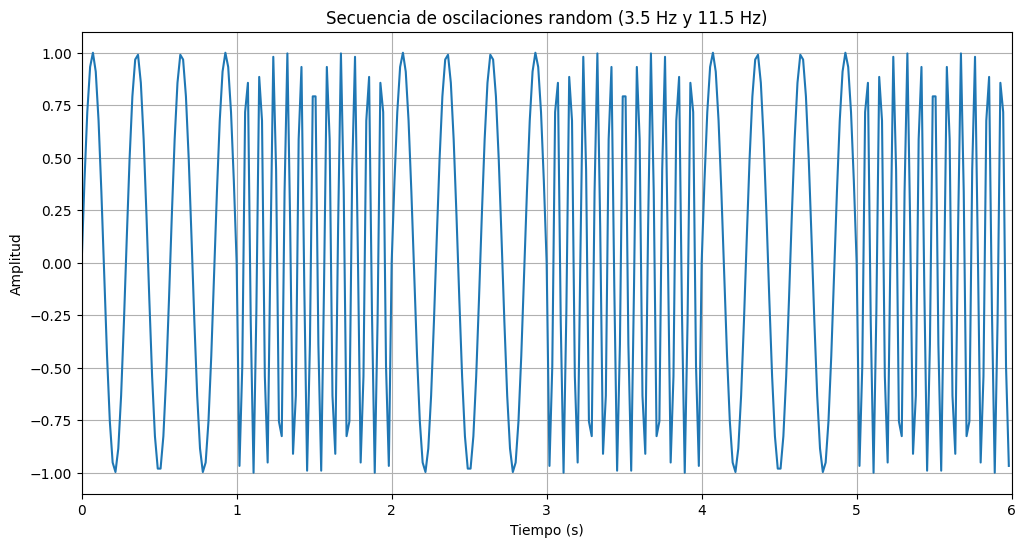

In [2]:
# Parámetros  
fs = 55            # Frecuencia de muestreo en Hz  
t_total = 6        # Duración total en segundos  
f1 = 3.5            # Frecuencia de la primera oscilación en Hz  
f2 = 11.5           # Frecuencia de la segunda oscilación en Hz  
duracion_segmento = 1  # Duración de cada segmento en segundos  
num_repeticiones = 6 # Número total de segmentos (3 de cada oscilacion) 

# vector de tiempo
t = np.arange(0, t_total, 1/fs) 

# Generamos las oscilaciones aleatorias   

amplitud = 1  # Amplitud aleatoria para la osc. 

# Inicializamos la secuencia  
secuencia = np.zeros_like(t)

# Llenar la secuencia con oscilaciones alternando  
for i in range(num_repeticiones):  
    if i % 2 == 0:  # Índices pares para la primera oscilación  
        start = i * duracion_segmento * fs  
        end = start + duracion_segmento * fs  
        secuencia[start:end] = amplitud  * np.sin(2 * np.pi * f1 * t[start:end])  
    else:  # Índices impares para la segunda oscilación  
        start = i * duracion_segmento * fs  
        end = start + duracion_segmento * fs  
        secuencia[start:end] = amplitud * np.sin(2 * np.pi * f2 * t[start:end])
# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(t, secuencia)  
plt.title('Secuencia de oscilaciones random (3.5 Hz y 11.5 Hz)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

## Implementación clásica.

In [3]:
# Parámetros
num_input_channels = 1      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 10   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = t.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)


# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

sec = secuencia.reshape(1, len(secuencia))


# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        #(0.05 * input2res @ secuencia[i, np.newaxis]) +
        (0.05 * input2res @ sec[:, i]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS.shape)
analytic_signal = hilbert(RS)
amplitude_envelope = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS.shape)
print(amplitude_envelope.shape)

(10, 331)
(10, 331)
(10, 331)
(10, 331)


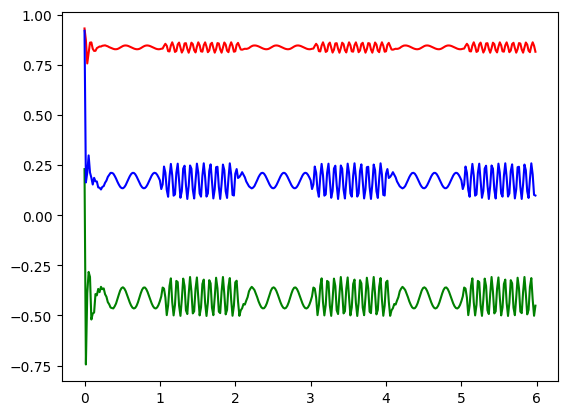

In [4]:
# estados puros del reservoir.
plt.plot(t, reservoir_states[0, 1:], color = 'green')
plt.plot(t, reservoir_states[1, 1:], color = 'red')
plt.plot(t, reservoir_states[2, 1:], color = 'blue')
plt.show()

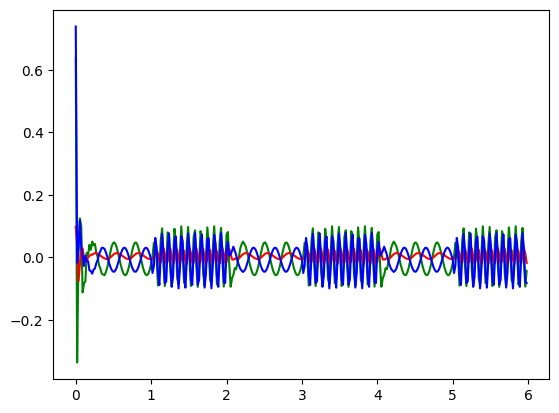

In [5]:
# estados centrados en el 0.
plt.plot(t, RS[0, 1:], color = 'green')
plt.plot(t, RS[1, 1:], color = 'red')
plt.plot(t, RS[2, 1:], color = 'blue')
plt.show()

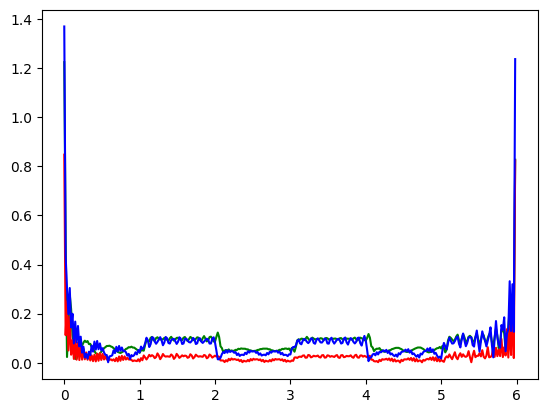

In [6]:
# envolvente de los estados.
plt.plot(t, amplitude_envelope[0, 1:], color = 'green')
plt.plot(t, amplitude_envelope[1, 1:], color = 'red')
plt.plot(t, amplitude_envelope[2, 1:], color = 'blue')
plt.show()

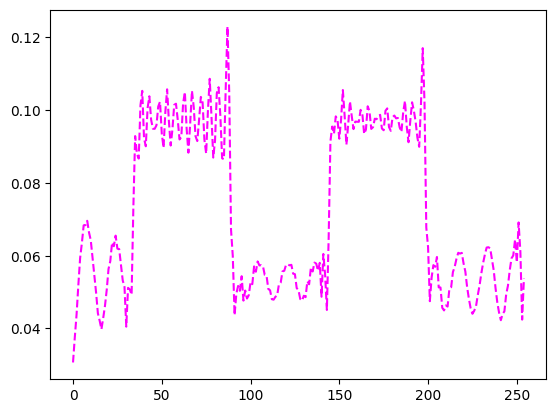

In [10]:
# Eliminamos los primeros 75 puntos para estabilizar el reservorio
stable_start = min(25, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
plt.plot(input_sequence[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [11]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.05530418 0.01246562 0.03981164 0.02770076 0.04996142 0.06230122
  0.01817166 0.12558583 0.10526604 0.0346401 ]
 [0.09357273 0.0255103  0.08678291 0.00732931 0.06093062 0.14261956
  0.09049389 0.10918343 0.14315909 0.11037576]]
(256,)


In [12]:
# Agrupamiento con algoritmo GMM(Gaussian Mixture Model).

from sklearn.mixture import GaussianMixture

def clustering_gmm(input_sequence, n_components=2):  
    """  
    Función para realizar agrupamiento usando GMM.  

    Args:  
    - input_sequence: Array de entrada procesado para el agrupamiento.  
    - num_clusters: Número de estados cerebrales. Default es 2.  

    Returns:  
    - labels: Etiquetas de los clústeres asignados a cada muestra de entrada. 
    """
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    cluster_labels = gmm.fit_predict(input_sequence.T)
    return cluster_labels

idx_gmm = clustering_gmm(input_sequence)

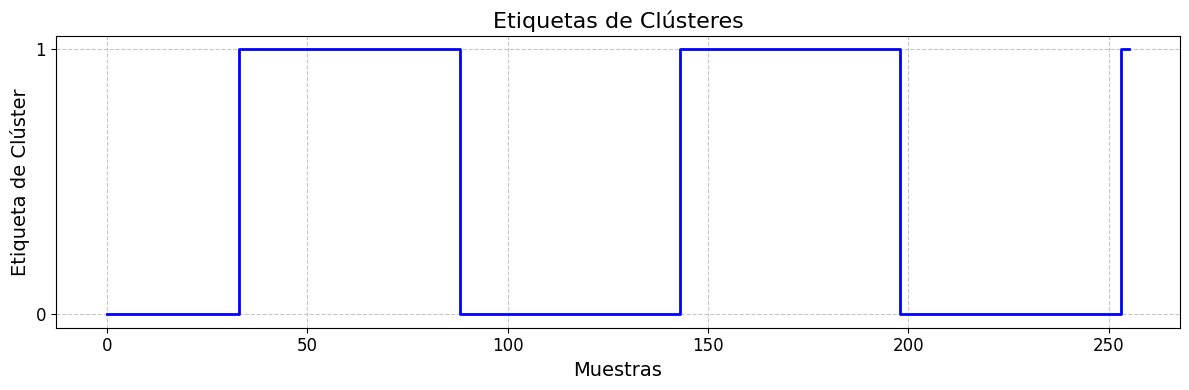

In [13]:
# Etiquetas con K-Means.
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

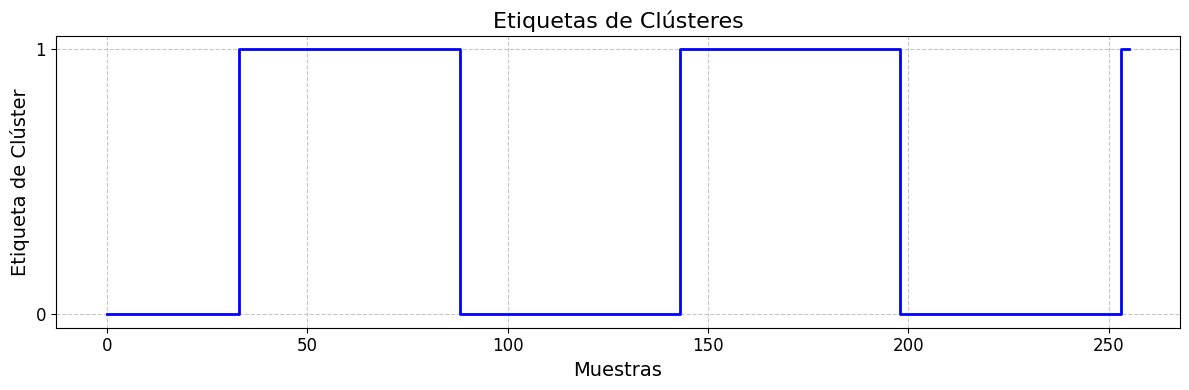

In [14]:
# Etiquetas con GMM.
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx_gmm, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

## Implementación cuántica.

In [33]:
# Número de qubits (tamaño del reservoir cuántico)
num_qubits = 5
# Profundidad del circuito del reservoir
num_layers = 1  

# Creamos un dispositivo cuántico
dev = qml.device("default.qubit", wires=num_qubits)

In [34]:
# Definimos el Quantum Reservoir  
def quantum_reservoir(reservoir_weights):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            # Entrelazamiento con el siguiente qubit (circular)  
            control_qubit = i 
            target_qubit = (i + 1) % num_qubits  
            qml.CNOT(wires=[control_qubit, target_qubit])

In [35]:
# Definicón del nodo cuántico
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights)
    
    # Vector de probabilidades de los estados de los qubits.
    return  qml.probs(wires=range(num_qubits)) 

In [36]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec = secuencia.reshape(1, len(secuencia))
input_series = sec
time_steps = input_series.shape[1]

# Run QESN
outputs = []
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_prob = quantum_echo_state_network(input_series[0, t0], prev_output, weights_in, weights_rc, reservoir_weights)

    final_output = np.tanh(q_prob) # aplicamos una tangente hiperbólica al vector de probabilidades.

    # Almacenamos el resultado en la lista.
    outputs.append(final_output)
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {final_output}")

# Convertimos outputs a numpy array.
outputs = np.array(outputs)

Step 0: [0.00217655 0.00356033 0.00772177 0.05156653 0.01822546 0.02164955
 0.00625671 0.04563967 0.07274658 0.10584481 0.01110054 0.01595343
 0.03563048 0.052945   0.00239494 0.0280746  0.00904899 0.032523
 0.00207706 0.02298011 0.00263576 0.00230002 0.02496544 0.06625378
 0.0688167  0.11818686 0.02042009 0.01742291 0.02908809 0.07567048
 0.01204061 0.01245846]
Step 1: [0.00190015 0.00391228 0.00538727 0.05214814 0.02297718 0.01805619
 0.00553415 0.04066463 0.07865001 0.09735059 0.01235597 0.01917585
 0.0360898  0.05219688 0.00095603 0.03139707 0.00677934 0.03402785
 0.00149301 0.0222437  0.00452826 0.00232801 0.02736497 0.05810496
 0.07055562 0.11986198 0.027699   0.01242514 0.02645942 0.07703135
 0.01432997 0.01443622]
Step 2: [0.00206037 0.00396173 0.00485997 0.05124566 0.02361328 0.01726769
 0.00507951 0.03828919 0.08029947 0.09526395 0.01311759 0.02038973
 0.03704589 0.05229236 0.00082668 0.03164315 0.00654236 0.03391369
 0.00124274 0.02144292 0.00496792 0.00225249 0.02709795 0.0

(32, 330)


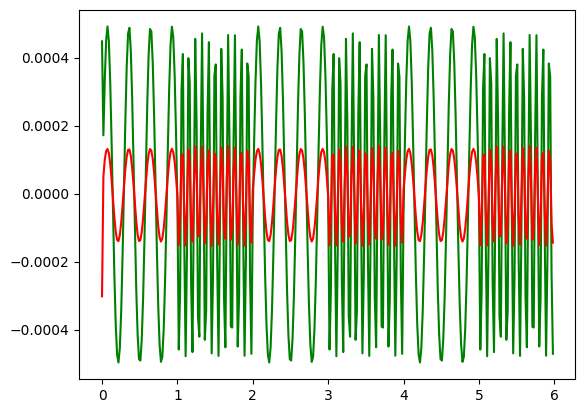

In [37]:
# Extracción de la envolvente superior usando Hilbert transform
outputs = outputs.T

RS_cuantico = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico.shape)

plt.plot(t, RS_cuantico[0, :], color = 'green')
plt.plot(t, RS_cuantico[1, :], color = 'red')
plt.show()

In [15]:
# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 1  # Frecuencia baja del filtro
highcut = 12  # Frecuencia alta del filtro

# Aplicamos filtro antes de Hilbert
x_filtered = bandpass_filter(RS_cuantico, lowcut, highcut, fs)

In [38]:
analytic_signal = hilbert(RS_cuantico)
amplitude_envelope = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope.shape)

(32, 330)
(32, 330)


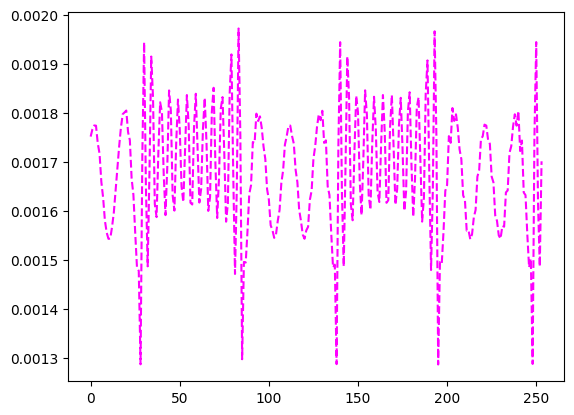

In [39]:
# Eliminamos los primeros puntos para estabilizar el reservorio.
stable_start = min(25, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
plt.plot(input_sequence[2, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [40]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[4.70888757e-04 1.34315325e-04 1.56951023e-03 2.66159458e-03
  1.72476281e-03 2.14291559e-03 1.49733328e-03 6.82581559e-03
  5.12903080e-03 5.02129583e-03 2.15614094e-03 3.24698394e-03
  3.08388312e-03 6.51805849e-04 4.70263928e-04 5.43376168e-04
  5.90475816e-04 3.02660145e-04 8.67401917e-04 2.41850295e-03
  1.17267273e-03 2.86476667e-04 1.14423161e-03 8.45866522e-03
  5.87972664e-03 3.77059835e-03 3.50768203e-03 3.09865556e-03
  3.68529225e-04 9.60409742e-05 3.19237694e-03 2.31130756e-03]
 [4.98465000e-04 1.46962894e-04 1.76188987e-03 2.86079980e-03
  1.94414023e-03 2.34348512e-03 1.71338211e-03 7.47399962e-03
  5.71534026e-03 5.29167732e-03 2.26940671e-03 3.37631192e-03
  3.36390602e-03 7.67182416e-04 5.99398197e-04 5.58204919e-04
  6.27373558e-04 2.50789814e-04 9.98722918e-04 2.65068138e-03
  1.25134656e-03 3.25374231e-04 1.20158623e-03 9.20847150e-03
  6.50077668e-03 4.15699723e-03 3.77086155e-03 3.40352484e-03
  4.33992746e-04 1.90591733e-04 3.369159

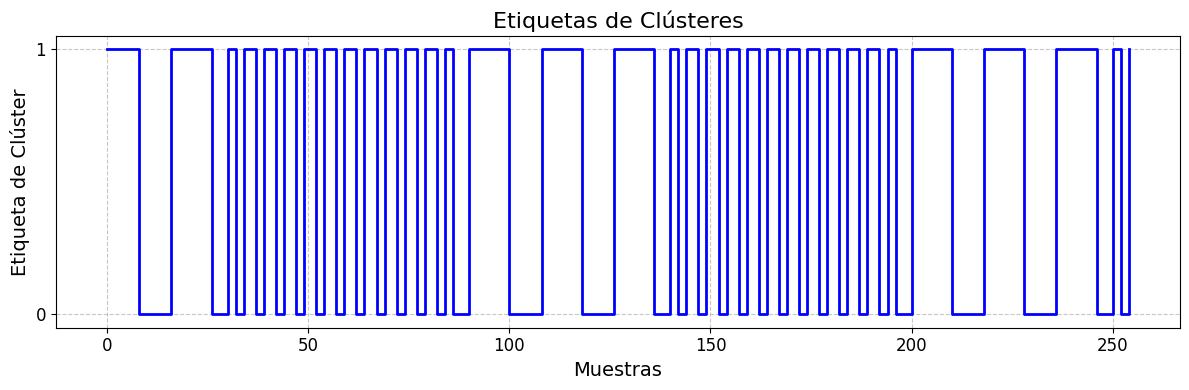

In [41]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

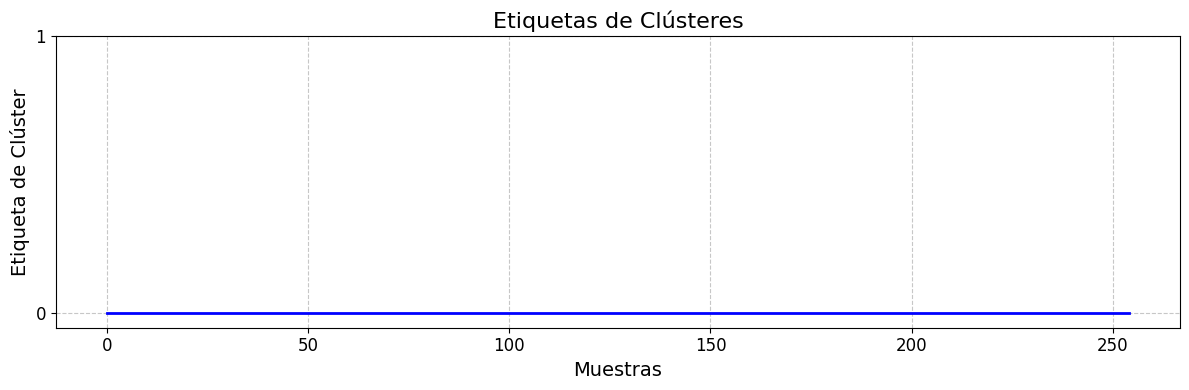

In [42]:
#clustering con GMM(Gaussian Mixture Model)
idx_gmm_cuant = clustering_gmm(input_sequence)

plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx_gmm_cuant, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

In [43]:
idx_gmm_cuant

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

## Implementación cuántica con estado.

In [20]:
# Número de qubits (tamaño del reservoir cuántico)
num_qubits = 3
# Profundidad del circuito
num_layers = 1  

# Creamos un dispositivo cuántico.
dev = qml.device("default.qubit", wires=num_qubits)

In [21]:
# Definimos el Quantum Reservoir  
def quantum_reservoir(reservoir_weights):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            # Entrelazamiento con el siguiente qubit (circular)  
            control_qubit = i 
            target_qubit = (i + 1) % num_qubits  
            qml.CNOT(wires=[control_qubit, target_qubit])

A diferencia de la otra implementación, devolvemos un vector de probabilidades de los estados del qubit en vez del expectation value.

In [22]:
# Define Quantum Node
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights)
    
    # Devolvemos un vector de probabilidades de los estados.
    return qml.probs(wires=range(num_qubits))

In [23]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec = secuencia.reshape(1, len(secuencia))
input_series = sec
time_steps = input_series.shape[1]

# Run QESN
outputs = []
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_prob = quantum_echo_state_network(input_series[0, t0], prev_output, weights_in, weights_rc, reservoir_weights)

    final_output = np.tanh(q_prob) # usamos la tanh de los estados cuánticos(en probabilidades)

    # Almacenamos el resultado en la lista.
    outputs.append(final_output)
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {final_output}")

# Convertimos outputs a numpy array.
outputs = np.array(outputs)

Step 0: [0.27590587 0.10438913 0.13312153 0.04214064 0.15848084 0.01181416
 0.00180616 0.25658865]
Step 1: [0.31219095 0.1289938  0.11786859 0.02769147 0.1352995  0.01463164
 0.00147877 0.24393052]
Step 2: [0.32687376 0.12889737 0.11950352 0.02518838 0.13701857 0.01343414
 0.00156488 0.22877921]
Step 3: [0.33119873 0.13077871 0.11867792 0.02420672 0.13573937 0.01458774
 0.00186332 0.22394743]
Step 4: [0.33308129 0.13115397 0.11857933 0.02388022 0.13558108 0.01477927
 0.00196048 0.22185809]
Step 5: [0.33157657 0.13025985 0.11908947 0.02398907 0.13618022 0.01433107
 0.00180956 0.22372425]
Step 6: [0.32681021 0.12822447 0.12006074 0.02456166 0.13738821 0.01344472
 0.00149244 0.22925513]
Step 7: [0.31918692 0.12532495 0.12121171 0.02557436 0.13888725 0.01257821
 0.00117787 0.23769822]
Step 8: [0.30960316 0.12197239 0.12226515 0.02694097 0.14033122 0.01214617
 0.00101901 0.24778751]
Step 9: [0.29949561 0.11867237 0.12305758 0.02847621 0.14146978 0.01228782
 0.00106802 0.25789348]
Step 10: [

In [24]:
outputs = outputs.T
outputs.shape

(8, 330)

(8, 330)


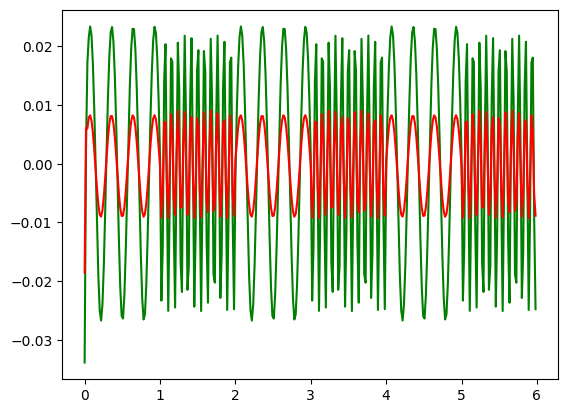

In [25]:
RS_cuantico2 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico2.shape)

plt.plot(t, RS_cuantico2[0, :], color = 'green')
plt.plot(t, RS_cuantico2[1, :], color = 'red')
plt.show()

In [26]:
# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 3.5  # Frecuencia baja del filtro
highcut = 11.5  # Frecuencia alta del filtro

# Aplicar filtro pasa banda antes de Hilbert
x_filtered2 = bandpass_filter(RS_cuantico2, lowcut, highcut, fs)

In [27]:
analytic_signal = hilbert(x_filtered2)
amplitude_envelope_cuant2 = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope_cuant2.shape)

(8, 330)
(8, 330)


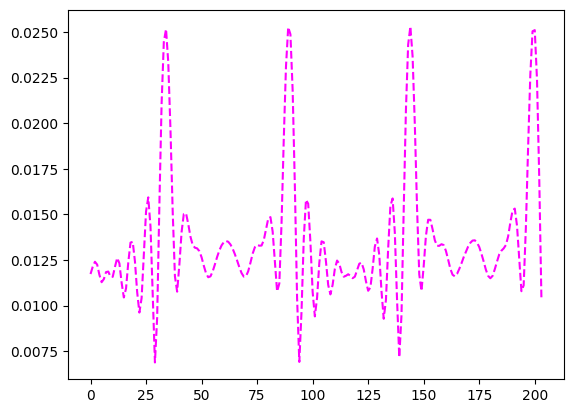

In [28]:
# Eliminamos primeros puntos del reservoir.
stable_start = min(75, amplitude_envelope_cuant2.shape[1])
input_sequence_cuant2 = amplitude_envelope_cuant2[:,stable_start:-50]
plt.plot(input_sequence_cuant2[0,1:], linestyle="dashed", color = 'magenta')
plt.show()

In [29]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_cuant2.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.01252588 0.00456148 0.00150387 0.00177645 0.00194278 0.00073422
  0.00025685 0.01293547]
 [0.02278246 0.00831403 0.0028326  0.0032065  0.00365718 0.00109663
  0.00038366 0.02386256]]
(205,)


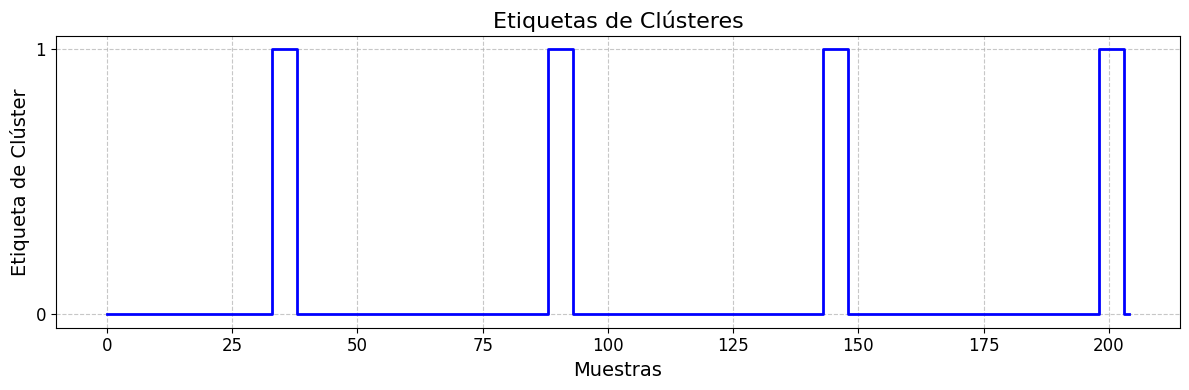

In [30]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuant2.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()